In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt

from statsmodels.stats.weightstats import _tconfint_generic as t_conf

In [2]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [4]:
# Приравниваем один из полов нулю, другой единице
data.SEX = data.SEX.map({1: 0, 2: 1})

df_good_clients = data[data['default'] == 0]
df_bad_clients  = data[data['default'] == 1]

meds_good_clients = df_good_clients.LIMIT_BAL.median() 
meds_bad_clients = df_bad_clients.LIMIT_BAL.median() 

In [5]:
# Гипотеза о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

# H0: means_good_clients == means_bad_clients
# H1: means_good_clients != means_bad_clients

alpha = 0.05

Посмотрим на распределение клиентов (вернувших и не вернувших кредит) в зависимости от объема кредитного лимита

Populating the interactive namespace from numpy and matplotlib


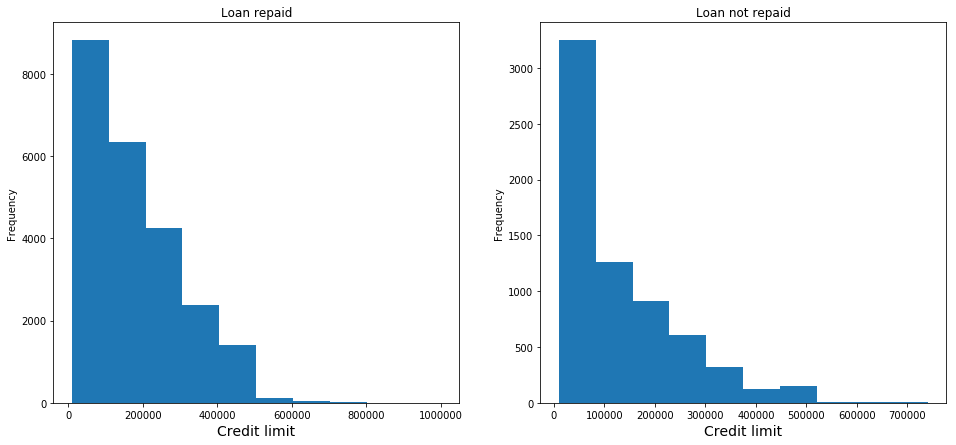

In [6]:
%pylab inline

plt.figure(figsize=(16,7))
plt.subplot(121)
df_good_clients['LIMIT_BAL'].plot.hist()
plt.xlabel('Credit limit', fontsize=14)
plt.title('Loan repaid')

plt.subplot(122)
df_bad_clients['LIMIT_BAL'].plot.hist()
plt.xlabel('Credit limit', fontsize=14)
plt.title('Loan not repaid')
pylab.show()

Видим, что вероятность невозврата кредита растет при очень низком уровне кредитного лимита и при высоком

In [7]:
# Построим 95% доверительные интервалы на основе бутстрепа

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

good_cl_vals = df_good_clients.LIMIT_BAL.values
bad_cl_vals = df_bad_clients.LIMIT_BAL.values

good_median_scores = list(map(np.median, get_bootstrap_samples(good_cl_vals, 1000)))
bad_median_scores = list(map(np.median, get_bootstrap_samples(bad_cl_vals, 1000)))


print ("95% confidence interval for bad clients:",  stat_intervals(good_median_scores, 0.05))
print ("95% confidence interval for good clients:",  stat_intervals(bad_median_scores, 0.05))

95% confidence interval for bad clients: [150000. 150000.]
95% confidence interval for good clients: [80000. 90000.]


Доверительные интерваля не пересекаются, поэтому гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки отвергаем

In [8]:
# Гипотеза о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

means_good_clients = df_good_clients.LIMIT_BAL.mean() 
means_bad_clients = df_bad_clients.LIMIT_BAL.mean() 

# H0: means_good_clients == means_bad_clients
# H1: means_good_clients != means_bad_clients

# Используем критерий Манна-Уитни

stats.mannwhitneyu(df_good_clients.LIMIT_BAL, df_bad_clients.LIMIT_BAL)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Так как критерий значимость по критерию Манна-Уитни меньше 0.05, то нулевую гипотезу о равенстве распределений отвергаем

In [9]:
# Значимы ли полученные результаты с практической точки зрения

def practice_p(a_mean, b_mean):
    if a_mean > b_mean:
        return a_mean / b_mean
    else:
        return - b_mean / a_mean

practice_p(df_good_clients.LIMIT_BAL.mean(), df_bad_clients.LIMIT_BAL.mean()),\
practice_p(df_good_clients.LIMIT_BAL.median(), df_bad_clients.LIMIT_BAL.median())

(1.3688432586435533, 1.6666666666666667)

Так как значимость сравнивается со значением 1.5, то результат об отсутствии различий медианн практически не значим а результат о неравенстве средних значений практически значим

### Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

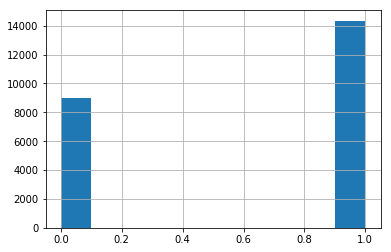

In [10]:
df_good_clients.SEX.hist();

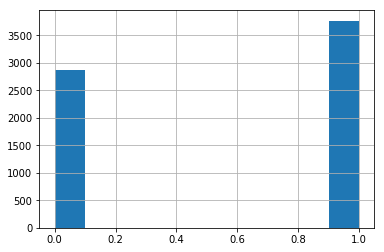

In [11]:
df_bad_clients.SEX.hist();

In [12]:
# Используем z-критерий разности долей независимых выборок

# H0: p_mens_good == p_mens_bad
# H1: p_mens_good != p_mens_bad

def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)



In [13]:
proportions_diff_z_test(proportions_diff_z_stat_ind(df_good_clients.SEX, df_bad_clients.SEX))

4.472866521609831e-12

Построим доверительный интервал для разности долей мужчин и женщин в выборках

In [14]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

proportions_confint_diff_ind(df_good_clients.SEX, df_bad_clients.SEX)

(0.03363493274962867, 0.060548077974896725)

Уровень значимости низок, интервал не содержит ноль - гендерный состав группы людей вернувших и не вернувших кредит отличается

### Задание 3

Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборот, не отдаст долг?

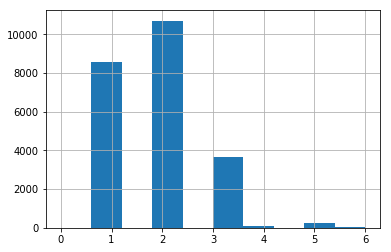

In [15]:
df_good_clients.EDUCATION.hist();

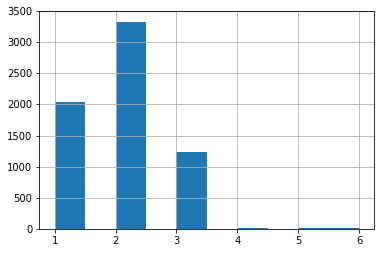

In [16]:
df_bad_clients.EDUCATION.hist();

Проверим зависимость между типом образования и наличием просрочки по кредиту.
Воспользуемся критерием хи-квадрат.

In [17]:
# H0: Зависимости нет
# H1: Зависимость есть

# Составим таблицу сопряженности

corr_table = [list(df_good_clients.groupby('EDUCATION').EDUCATION.count()), 
              [0] + list(df_bad_clients.groupby('EDUCATION').EDUCATION.count())]
print(corr_table)

[[14, 8549, 10700, 3680, 116, 262, 43], [0, 2036, 3330, 1237, 7, 18, 8]]


In [18]:
# Для приведения к единому масштабу, построим долю заемщиков невернувших долг

scaled_corr_table = [j / (i + j) for i, j in zip(corr_table[0], corr_table[1])]

print(scaled_corr_table)

[0.0, 0.19234766178554558, 0.23734853884533144, 0.2515761643278422, 0.056910569105691054, 0.06428571428571428, 0.1568627450980392]


In [19]:
# Коэффициент V-Крамера:

def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

cramers_stat(np.array(corr_table))

0.07376009713252163

Учитывая, что людей с образованием 0 слишком мало и нельзя делать по ним какие-то выводы, то наилучший индикатор возврата долга - наличие образования 4. Лучший индикатор невозврата долга - образование 3

### Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

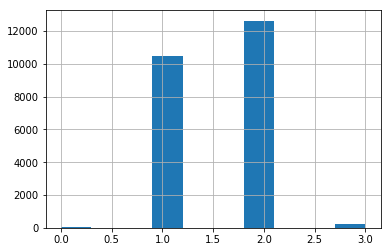

In [20]:
df_good_clients.MARRIAGE.hist();

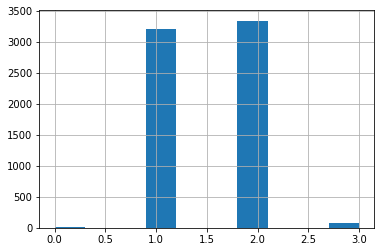

In [21]:
df_bad_clients.MARRIAGE.hist();

Видим, что женатые люди более склонны к невозврату кредита

In [22]:
# Для измерения связи между переменными MARRIAGE  и default, предлагается использовать 
# Коэффициент V Крамера

# Введем таблицу сопряженности:

corr_table_marr = np.array([list(df_good_clients.groupby('MARRIAGE').EDUCATION.count()), 
              list(df_bad_clients.groupby('MARRIAGE').EDUCATION.count())])
print(corr_table_marr)

[[   49 10453 12623   239]
 [    5  3206  3341    84]]


In [23]:
# Посчитаем непосредственно коэффициент V Крамера:

V_coef = cramers_stat(corr_table_marr)
print(V_coef)

0.034478203662766466


По коэффициенту понятно, что взаимосвязь очень мала

### Задание 5

Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

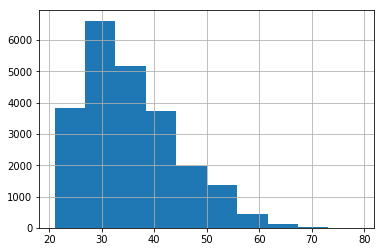

In [24]:
df_good_clients.AGE.hist();

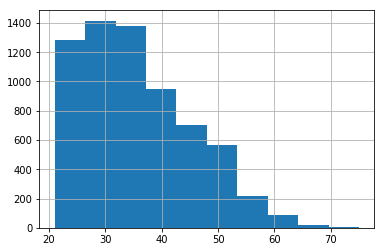

In [25]:
df_bad_clients.AGE.hist();

По полученным графикам видно, что люди в возрасте от двадцати до двадцадти пяти лет и в возрасте от тридцадти двух до тридцадти семи лет более склонны не вернуть кредит

In [26]:
# Проверим гипотезу о равенстве медианных значений возрастов людей
# H0: med_age_good == med_age_bad
# H1: med_age_good != med_age_bad

med_age_good = df_good_clients.AGE.median()
med_age_bad  = df_bad_clients.AGE.median()
med_age_good, med_age_bad

(34.0, 34.0)

In [27]:
# Построим доверительные интервалы для медианных оценок на основе бутстрепа:

good_age_vals = df_good_clients.AGE.values
bad_age_vals = df_bad_clients.AGE.values

good_median_scores = list(map(np.median, get_bootstrap_samples(good_age_vals, 1000)))
bad_median_scores = list(map(np.median, get_bootstrap_samples(bad_age_vals, 1000)))


print ("95% confidence interval age for bad clients:",  stat_intervals(good_median_scores, 0.05))
print ("95% confidence interval age for good clients:",  stat_intervals(bad_median_scores, 0.05))

95% confidence interval age for bad clients: [34. 34.]
95% confidence interval age for good clients: [34. 35.]


Доверительные интервалы пересекаются, что свидетельствует в пользу равенства медиан

In [28]:
# Проверим гипотезу о равенстве распределений с помощью перестановочного критерия
# H0: распределения равны
# H1: распределения не равны

def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = [i for i in range(n1 + n2)]
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

permutation_test(df_good_clients.AGE, df_bad_clients.AGE, max_permutations = 1000)

0.019

Уровень значимости мал, поэтому мы отвергаем нулевую гипотезу о равенстве распределений